In [2]:
import os

#### Check The Dataset

In [ ]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

PATH = "LETTERS_NUMS"
walk_through_dir(PATH)

#### Create train_test split dirs

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split as tts

def split_dir(dir_path, dataset_path, train):
    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')
    
    # Create train and test directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for subdir in next(os.walk(dir_path))[1]:  # List of subdirectories in dir_path
        subdir_path = os.path.join(dir_path, subdir)
        images = [os.path.join(subdir_path, img) for img in os.listdir(subdir_path) if img.endswith(('jpg', 'jpeg', 'png', 'heic'))]
        
        print(f"Found {len(images)} images in {subdir_path}")

        if len(images) < train:
            print(f"Not enough images to split {subdir_path}, skipping...")
            continue

        train_images, test_images = tts(images, train_size=train, shuffle=True)
        
        print(f"Splitting {len(train_images)} images to training and {len(test_images)} images to testing for {subdir_path}")
        print("--------------------------------------------------------------------")

        # Create subdirectories in train and test directories
        train_subdir = os.path.join(train_dir, subdir)
        test_subdir = os.path.join(test_dir, subdir)

        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)
        
        # Copy files to train directory
        for img in train_images:
            print(f"COPYING {img} TO TRAINING DIR")
            shutil.copy(img, os.path.join(train_subdir, os.path.basename(img)))
        
        # Copy files to test directory
        for img in test_images:
            print(f"COPYING {img} TO TESTING DIR")
            shutil.copy(img, os.path.join(test_subdir, os.path.basename(img)))
        
        print(f"SPLITTING DONE DATASET SAVE TO: {dataset_path}")

In [ ]:
SPLITTED_DATASET = "DATASET"
split_dir(PATH, SPLITTED_DATASET, train=70)

In [8]:
train_dir = "DATASET/train"
test_dir  = "DATASET/test"

train_dir,test_dir

('DATASET/train', 'DATASET/test')

#### Visualizing the image

Random image path: DATASET\train\1\C_1 (11).jpg
Image class: 1
Image height: 480
Image width: 640


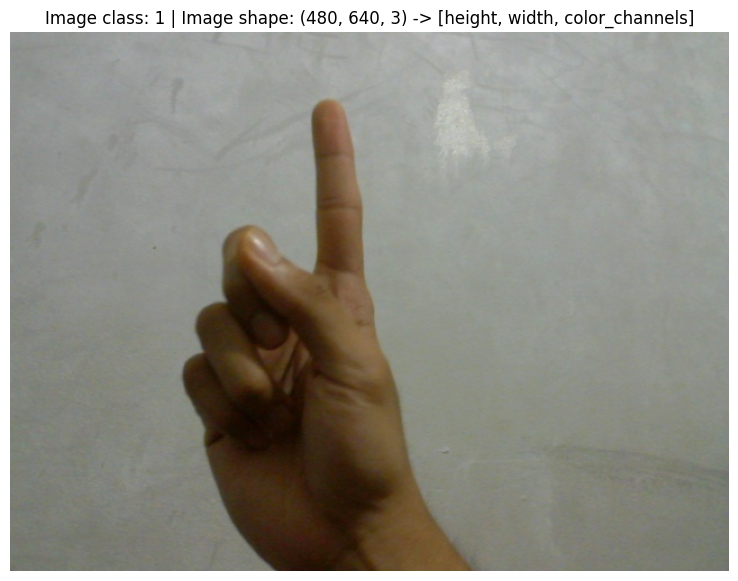

In [9]:
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set seed
# random.seed(30) # <- try changing this and see what happens

# Convert SAVE_DATASET_PATH to a Path object
save_dataset_path = Path(SPLITTED_DATASET)

# 1. Get all image paths (* means "any combination")
image_extensions = ["*.jpg", "*.jpeg", "*.JPG", "*.png", "*.PNG"]
image_path_list = []

for ext in image_extensions:
    image_path_list.extend(save_dataset_path.rglob(ext))

# Check if the list is empty
if not image_path_list:
    print("No images found in the specified path.")
else:
    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem

    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}") 
    print(f"Image width: {img.width}")
    # img.show()  # Display the image

    # Turn the image into an array
    img_as_array = np.asarray(img)

    # Plot the image with matplotlib
    plt.figure(figsize=(10, 7))
    plt.imshow(img_as_array)
    plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
    plt.axis(False);

#### Transforming Dataset


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # Resize the images to 64x64
    transforms.Resize(size=(266, 266)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [ ]:
plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

#### Loading Image Data Using ImageFolder

In [33]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2450
    Root location: DATASET/train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               Resize(size=(266, 266), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 4550
    Root location: DATASET/test
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               Resize(size=(266, 266), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


#### Classes

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

In [36]:
len(train_data), len(test_data)

(2450, 4550)

#### Check One Image

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 266, 266])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 266, 266]) -> [color_channels, height, width]
Image permute shape: torch.Size([266, 266, 3]) -> [height, width, color_channels]


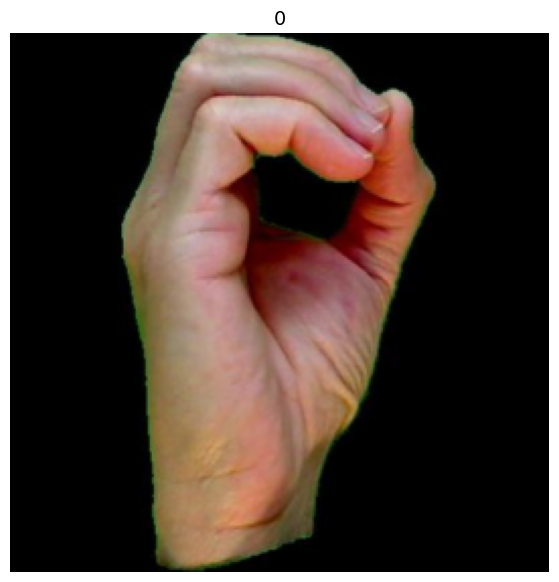

In [ ]:
# Rearrange the order of dimensions, so that matplotlib can read it
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

#### DataLoaders

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b108c37d30>,
 <torch.utils.data.dataloader.DataLoader at 0x1b108c3b6a0>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 266, 266]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


#### Function to display random images

In [ ]:
from typing import List
import torch
import random
import matplotlib.pyplot as plt

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    """
    Display a random sample of images from the dataset.

    Parameters:
    - dataset: The dataset from which to display images.
    - classes: Optional list of class names to display along with the images.
    - n: Number of random images to display.
    - display_shape: Whether to display the shape of the images.
    - seed: Random seed for reproducibility.
    """
    if seed is not None:
        random.seed(seed)

    # Get a random sample of indices
    indices = random.sample(range(len(dataset)), n)
    
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        
        # Convert image to numpy array for displaying
        img = img.numpy().transpose((1, 2, 0))  # Assuming image is in CHW format
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        if classes:
            axes[i].set_title(f'Class: {classes[label]}')
        if display_shape:
            axes[i].set_xlabel(f'Shape: {img.shape}')
    
    plt.tight_layout()
    plt.show()

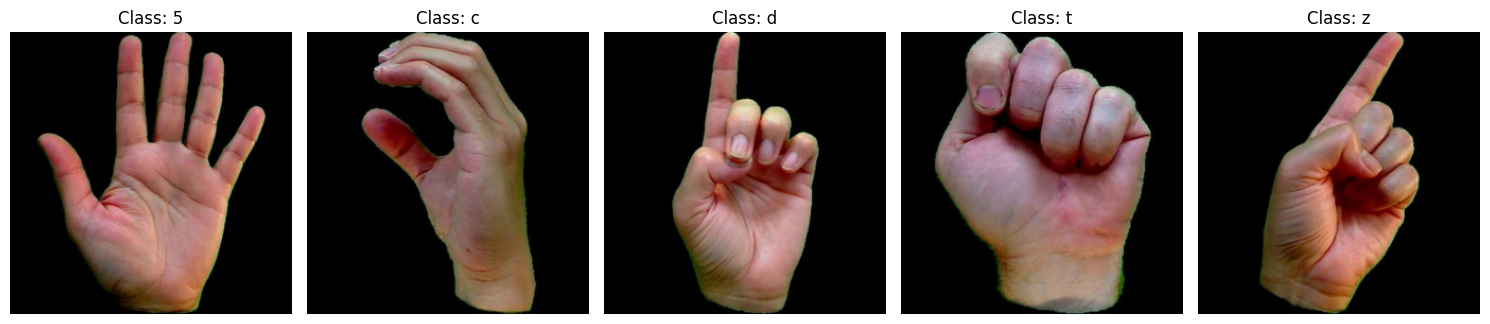

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

In [ ]:
mnetv2 = models.MobileNet_V2_Weights.DEFAULT
model_transoforms = mnetv2.transforms()
model_transoforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)